In [31]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill Missing Courses

In [32]:
df = pd.read_csv('../data/course_cleaned.csv', header=0, encoding='unicode_escape')

In [33]:
def append_missing_course(df):
    # Get distinct values of 'Term' and 'Course Yr'
    distinct_terms = df['Term'].unique()
    distinct_course_yrs = df['Term Yr'].unique()
    # Generate new dataframe with missing distinct courses
    new_rows = []
    for term in distinct_terms:
        for course_yr in distinct_course_yrs:
            distinct_courses = df[(df['Term'] == term)]['Course'].unique()
            courses = df[(df['Term'] == term) & (df['Term Yr'] == course_yr)]['Course'].unique()
            missing_courses = np.setdiff1d(distinct_courses, courses)
            for missing_course in missing_courses:
                selected_row = df[df['Course'] == missing_course]
                new_rows.append({
                    'Term': term,
                    'Term Yr': course_yr,
                    'Course': missing_course,
                    'Class Yr': selected_row['Class Yr'].values[0],
                    'Dept Desc': selected_row['Dept Desc'].values[0],
                    'Cap': np.nan,
                    'Enrolled': np.nan
                })

    new_df = pd.DataFrame(new_rows)
    # Concatenate the original dataframe with the new dataframe
    courses_df = pd.concat([df, new_df], ignore_index=True)
    return courses_df

In [34]:
courses = append_missing_course(df)

# Impute and Transform Data

In [35]:
cat_cols = courses.select_dtypes(include=['object']).columns

In [36]:
def transform_data(courses_df):
    # create a pipeline to impute missing values with the mean and scale numeric features
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    # create a pipeline to impute missing values with the most frequent value and one-hot encode categorical features
    categorical_pipeline = Pipeline([
        ('encoder', OrdinalEncoder())
    ])

    # create a column transformer to apply the numeric and categorical pipelines to the correct features
    # use remainder='passthrough' to keep the remaining features in the dataframe
    column_transformer = ColumnTransformer([
        ('numeric_transformer', numeric_pipeline, ['Class Yr']),
        ('categorical_transformer', categorical_pipeline, cat_cols)
    ], remainder='passthrough',verbose_feature_names_out=False)

    # fit_transform the preprocessor on the penguins dataset
    # convert the result to a dataframe
    # use the preprocessor's get_feature_names_out() method to get the column names
    transformed_data = column_transformer.fit_transform(courses_df)
    transformed_df = pd.DataFrame(transformed_data, columns=column_transformer.get_feature_names_out())

    imputer = IterativeImputer(max_iter=10, random_state=0)
    transformed_df = pd.DataFrame(np.round(imputer.fit_transform(transformed_df)), columns=transformed_df.columns)
    df_prepared = transformed_df.copy()
    df_prepared[cat_cols] = column_transformer.named_transformers_['categorical_transformer'].inverse_transform(transformed_df[cat_cols])
    df_prepared['Class Yr'] =  column_transformer.named_transformers_['numeric_transformer'].inverse_transform(transformed_df[['Class Yr']]).astype(int)
    df_prepared['Class Yr'] = df_prepared['Class Yr'].replace(2, 3)
    df_prepared['Class Yr'] = df_prepared['Class Yr'].replace(1, 2)
    df_prepared['Class Yr'] = df_prepared['Class Yr'].replace(0, 1)
    df_prepared['Term Yr'] = df_prepared['Term Yr'].astype(int)
    return df_prepared


In [37]:
def compute_tfidf_scores(title):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_scores = tfidf_vectorizer.fit_transform(title)
    summed_scores = tfidf_scores.sum(axis=1)
    return summed_scores

In [38]:
# impute data and convert 
course_prepared = transform_data(courses)
course_prepared['TF_IDF'] = compute_tfidf_scores(course_prepared['Title'])
course_prepared.drop(columns='Title', inplace=True,axis=1)
course_prepared

/Users/bhavy/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Class Yr,Course,Term,Dept Desc,Term Yr,Cap,Enrolled,TF_IDF
0,1,CSC 111,Fall,Computer Science,2019,400.0,346.0,1.999042
1,1,CSC 115,Fall,Computer Science,2019,150.0,130.0,1.697958
2,1,CSC 115,Summer,Computer Science,2019,115.0,86.0,1.697958
3,2,CSC 225,Fall,Computer Science,2019,215.0,197.0,1.727549
4,2,CSC 225,Summer,Computer Science,2019,145.0,63.0,1.727549
...,...,...,...,...,...,...,...,...
215,3,SENG 310,Spring,Computer Science,2022,122.0,107.0,2.219697
216,3,SENG 321,Spring,Computer Science,2022,120.0,106.0,2.219697
217,3,SENG 371,Spring,Computer Science,2022,113.0,104.0,1.732051
218,4,SENG 401,Spring,Computer Science,2022,107.0,97.0,1.413005


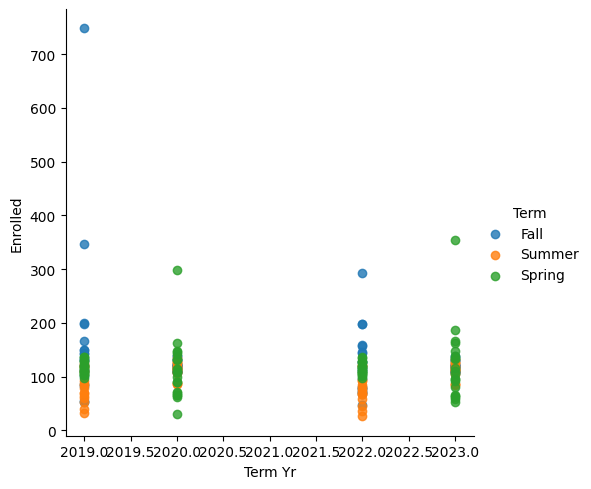

In [39]:
sns.lmplot(data=course_prepared, x='Term Yr',y='Enrolled',hue='Term',fit_reg=False)

In [40]:
course_prepared["Course"].value_counts()

Course
CSC 115     12
CSC 225     12
CSC 226     12
CSC 230     12
CSC 320     12
CSC 360     12
SENG 310    12
CSC 370     12
SENG 275    12
SENG 265    12
CSC 111      8
SENG 321     8
ECE 360      8
ECE 310      8
ECE 260      8
CSC 361      8
ECE 355      4
ECE 255      4
CSC 355      4
SENG 350     4
SENG 360     4
SENG 426     4
SENG 440     4
SENG 499     4
CSC 460      4
ECE 455      4
ECE 458      4
SENG 371     4
SENG 401     4
Name: count, dtype: int64

In [41]:
course_prepared = course_prepared.reindex(columns=['Course','TF_IDF','Term','Term Yr','Class Yr','Dept Desc','Cap','Enrolled'])
course_prepared.to_csv('../data/course_prepared.csv', index=False)